# Import modules and libraries

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle

# Import and read dataset and drop records for 2021 & 2022

In [10]:
df = pd.read_csv('220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv')
df = df[df.MONAT.isin(['Summe'])==False]
df = df[df.JAHR.isin([2021,2022])==False]

# Explore number of uniques per attribute

In [11]:
df.nunique()

MONATSZAHL                           3
AUSPRAEGUNG                          3
JAHR                                21
MONAT                              252
WERT                               822
VORJAHRESWERT                      806
VERAEND_VORMONAT_PROZENT          1374
VERAEND_VORJAHRESMONAT_PROZENT    1287
ZWOELF_MONATE_MITTELWERT           647
dtype: int64

# Explore wieght of each unique value in 'MONATSZAHL'

In [12]:
df.MONATSZAHL.value_counts()

Verkehrsunfälle    756
Alkoholunfälle     504
Fluchtunfälle      504
Name: MONATSZAHL, dtype: int64

# Explore wieght of each unique value in 'AUSPRAEGUNG'

In [13]:
df.AUSPRAEGUNG.value_counts()

insgesamt                 756
Verletzte und Getötete    756
mit Personenschäden       252
Name: AUSPRAEGUNG, dtype: int64

# Reset the index and extract only month value from 'MONAT' attribute 

In [14]:
df.reset_index(drop=True, inplace=True)

In [15]:
df['MONAT']=df['MONAT'].astype(str).str[-2:].astype(np.int64)

# Cleanup the dataset and focus on distributions over time for 'MONATSZAHL' attribute

In [16]:
df = df[['MONATSZAHL','AUSPRAEGUNG','JAHR','MONAT','WERT']]

In [17]:
df=df[df.MONAT.isin(['Summe'])==False]

In [18]:
df=df[df.AUSPRAEGUNG.isin(['insgesamt'])==True]

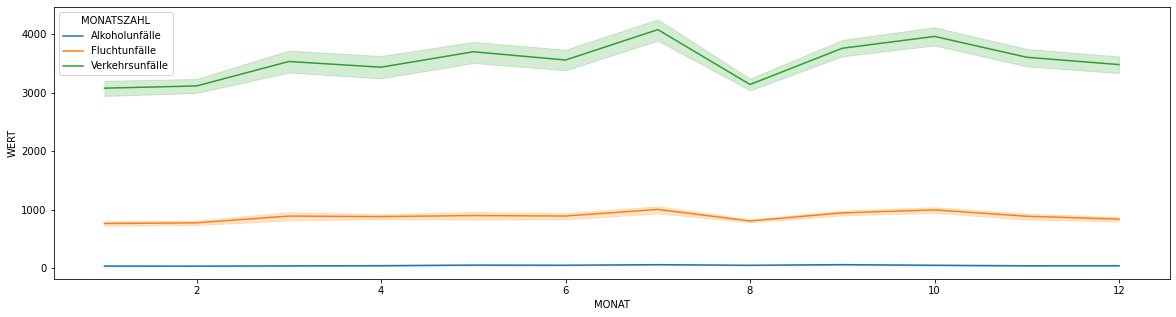

In [19]:
plt.figure(figsize = (20, 5))
sns.lineplot(data=df,x="MONAT", y="WERT", hue='MONATSZAHL');

# Illustrate weight of each category of 'MONATSZAHL'

<Figure size 432x288 with 0 Axes>

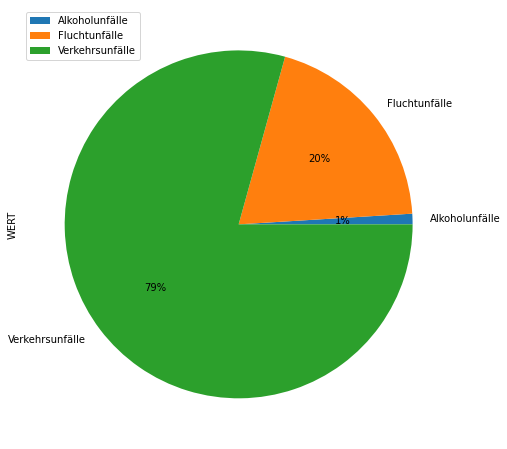

In [38]:

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

df.groupby(['MONATSZAHL']).sum().plot(kind='pie', y='WERT',figsize=(10,8),autopct='%.0f%%');
plt.savefig(f'Monatszahl_Pie.png',dpi=90, facecolor=fig.get_facecolor(), edgecolor='None')

# Graph to demonstrate rate of 'insgesamt' value per year per each category

### Alkoholunfälle

In [40]:
df_Alk_ins = df.loc[(df['MONATSZAHL'] == 'Alkoholunfälle') & (df['AUSPRAEGUNG'] == 'insgesamt')]

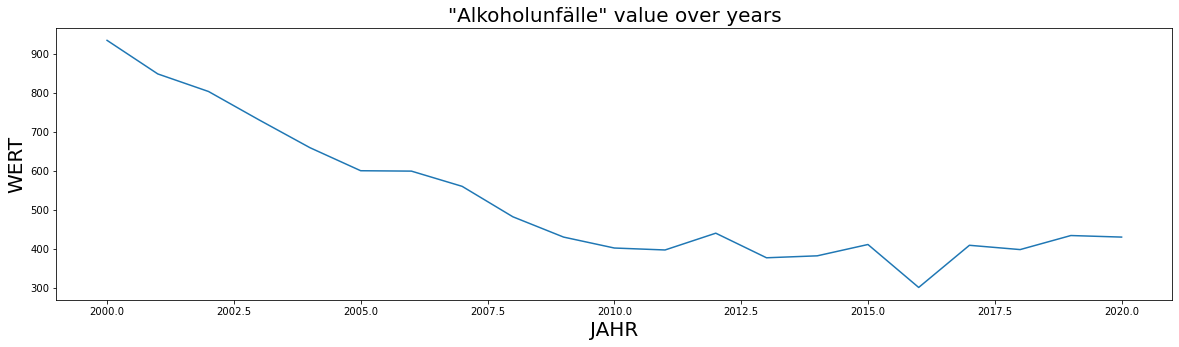

In [66]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=df_Alk_ins.groupby(['JAHR']).sum(),x="JAHR", y="WERT");
ax.set_title('"Alkoholunfälle" value over years', fontsize=20)
ax.set_xlabel('JAHR', fontsize=20)
ax.set_ylabel('WERT', fontsize=20)
plt.savefig(f'Alkoholunfälle.png',dpi=90, facecolor=fig.get_facecolor(), edgecolor='None')

### Fluchtunfälle

In [48]:
df_Flucht_ins = df.loc[(df['MONATSZAHL'] == 'Fluchtunfälle') & (df['AUSPRAEGUNG'] == 'insgesamt')]

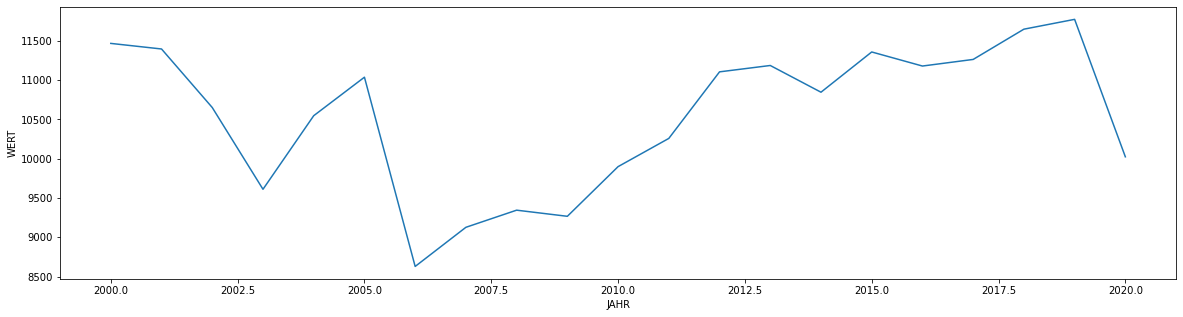

In [49]:
plt.figure(figsize = (20, 5))
sns.lineplot(data=df_Flucht_ins.groupby(['JAHR']).sum(),x="JAHR", y="WERT");
plt.savefig(f'Fluchtunfälle.png',dpi=90, facecolor=fig.get_facecolor(), edgecolor='None')

### Verkehrsunfälle

In [51]:
df_Verkehr_ins = df.loc[(df['MONATSZAHL'] == 'Verkehrsunfälle') & (df['AUSPRAEGUNG'] == 'insgesamt')]

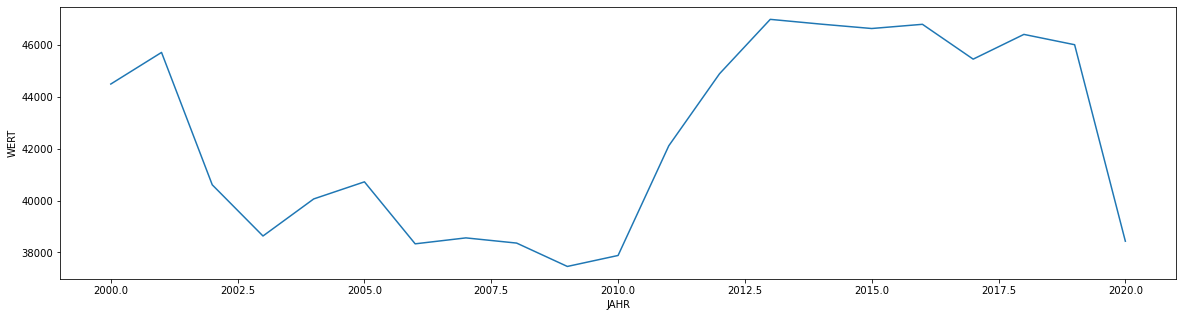

In [52]:
plt.figure(figsize = (20, 5))
sns.lineplot(data=df_Verkehr_ins.groupby(['JAHR']).sum(),x="JAHR", y="WERT");
plt.savefig(f'Verkehrsunfälle.png',dpi=90, facecolor=fig.get_facecolor(), edgecolor='None')

# ML Model

## Read dataset along with dropping records of 2021 and 2022

In [62]:
df = pd.read_csv('220511_monatszahlenmonatszahlen2204_verkehrsunfaelle.csv')
df = df[df.MONAT.isin(['Summe'])==False]
df = df[df.JAHR.isin([2021,2022])==False]

## Check null values in dataset

<AxesSubplot:>

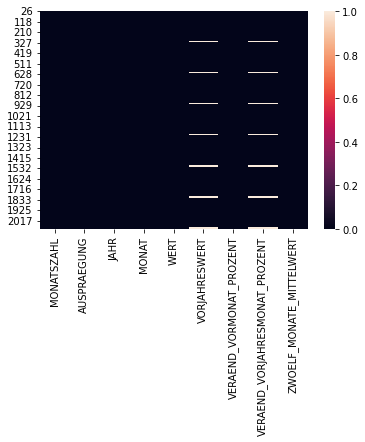

In [63]:
sns.heatmap(df.isna())

# Feature engineering for numericals

In [64]:
numeric_features = ['WERT']

# Feature engineering for categoricals

In [65]:
df.fillna(method='ffill',inplace=True)
categorical_features = ['MONATSZAHL','AUSPRAEGUNG','JAHR','MONAT']

In [66]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore") # Handle unknown means it will ignore nan's if it finds them

# Using ColumnTransformer for categorical features

In [67]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough')

# Create pipeline for preprocessing and modeling

In [68]:
pipeline = make_pipeline(preprocessor, linear_model.LinearRegression(normalize=True))

# Split the dataset

### Here the 'VORJAHRESWERT' is added to the model's input to incease the accuracy and preformance of the model

### The value of 'VORJAHRESWERT' could be driven from model prediction consequently for years and be utilized as input for specific year

In [69]:
X = df[['MONATSZAHL','AUSPRAEGUNG','JAHR','MONAT','VORJAHRESWERT']]
y = df['WERT']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 52)

In [71]:
type(X_train), X_train.shape, y_train.shape, X_test.shape

(pandas.core.frame.DataFrame, (1234, 5), (1234,), (530, 5))

# Fit the model on train data

In [72]:
pipeline.fit(X_train, y_train)

/Users/sima/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MONATSZAHL', 'AUSPRAEGUNG',
                                                   'JAHR', 'MONAT'])])),
                ('linearregression', LinearRegression(normalize=True))])

# Calculate the accuracy score from test data

In [73]:
print("model score: %.3f" % pipeline.score(X_test, y_test))
print("model score: %.3f" % pipeline.score(X_train, y_train))

model score: 0.982
model score: 0.990


# Forecast desired values:

In [74]:
input_data = {'MONATSZAHL':['Alkoholunfälle'],'AUSPRAEGUNG':['insgesamt'],'JAHR':['2021'],'MONAT':['01'],'VORJAHRESWERT':['28']}
preprocessed_data = pd.DataFrame(data=input_data)

In [75]:
pipeline.predict(preprocessed_data)

array([36.41809366])

# Save the model for application use

In [77]:
filename = 'pipeline.pkl'
pickle.dump(pipeline, open(filename, 'wb'))